# LSTM - bert128

- **Training set**: LO_SARD102
- **Test/Validation set:** JTT
- **Features**: bert sequence (128)
- **Class imbalance processing**: Class weights

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from helper_functions import *
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from collections import Counter

X_train = numpy.load('/mnt/md0/user/scheuererra68323/LOSARD102_bert128_X.npy')
Y_train = pd.read_hdf('/mnt/md0/user/scheuererra68323/LOSARD102_bert128_y.h5').is_vulnerable.values

X_test = numpy.load('/mnt/md0/user/scheuererra68323/JTT_bert128_X.npy')
Y_test = pd.read_hdf('/mnt/md0/user/scheuererra68323/JTT_bert128_y.h5').is_vulnerable.values

X_train, X_val, Y_train, Y_val = train_test_split(
    X_train, Y_train, stratify=Y_train, test_size=0.2, random_state=10
)
print("Training dataset label counts:", Counter(Y_train))
classWeights = {
    0: ( 1 / Counter(Y_train)[0] ) * Y_train.shape[0] / 2.0 ,
    1: ( 1 / Counter(Y_train)[1] ) * Y_train.shape[0] / 2.0
}
print(f"\nclassWeights: {classWeights}\n")

print(X_train.shape)
print(Y_train.shape)
print(X_val.shape)
print(Y_val.shape)
print(X_test.shape)
print(Y_test.shape)

Training dataset label counts: Counter({0: 40584, 1: 366})

classWeights: {0: 0.5045091661738617, 1: 55.942622950819676}

(40950, 128, 768)
(40950,)
(10238, 128, 768)
(10238,)
(7972, 128, 768)
(7972,)


In [16]:
def run_classifier():
    model = keras.Sequential()
    model.add( layers.LSTM(256, input_shape=(X_train.shape[1], X_train.shape[2]), 
                          return_sequences=True) )
    model.add( layers.Dropout(0.1) )
    model.add( layers.TimeDistributed(layers.Dense(16)) )
    model.add( layers.Flatten())
    model.add( layers.Dense(1, activation='sigmoid') )

    model.summary()
    model.compile(loss='binary_crossentropy',
                  optimizer='adam', 
                  metrics=['accuracy']
                 )
    
    classWeights = {
        0: ( 1 / Counter(Y_train)[0] ) * Y_train.shape[0] / 2.0 ,
        1: ( 1 / Counter(Y_train)[1] ) * Y_train.shape[0] / 2.0
    }
    print(f"\nclassWeights: {classWeights}\n")

    history = model.fit(X_train, Y_train,
                        batch_size=512,
                        epochs=8,
                        verbose=True,
                        validation_data=(X_val, Y_val),
                        class_weight=classWeights
                        )
    
    return model, history


model, history = run_classifier()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_5 (LSTM)                (None, 128, 256)          1049600   
_________________________________________________________________
dropout_5 (Dropout)          (None, 128, 256)          0         
_________________________________________________________________
time_distributed_5 (TimeDist (None, 128, 16)           4112      
_________________________________________________________________
flatten_5 (Flatten)          (None, 2048)              0         
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 2049      
Total params: 1,055,761
Trainable params: 1,055,761
Non-trainable params: 0
_________________________________________________________________

classWeights: {0: 0.5045091661738617, 1: 55.942622950819676}

Epoch 1/8
80/80 [==============================

              precision    recall  f1-score   support

           0       0.99      1.00      0.99      7879
           1       0.14      0.01      0.02        93

    accuracy                           0.99      7972
   macro avg       0.57      0.50      0.51      7972
weighted avg       0.98      0.99      0.98      7972

Confusion matrix:
[[7873    6]
 [  92    1]]

Confusion matrix (Percentages):
[[9.8758e+01 7.5000e-02]
 [1.1540e+00 1.3000e-02]]

Metrics:
Sensitivity (TPR): 0.010753
Specifity (TNR):   0.999238

FPR: 0.000762
FNR: 0.989247

Balanced accuracy: 0.504996

Test loss:	0.083175
Test accuracy:	0.987707


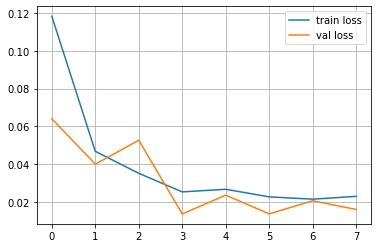

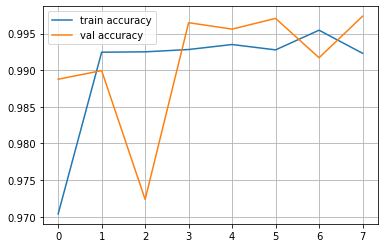

In [17]:
def evaluate_classifier(_model, _history):
    Y_pred = numpy.round(_model.predict(X_test))

    print(classification_report(Y_test, Y_pred))
    print_metrics(confusion_matrix(Y_test, Y_pred), Y_test)
    print()
    score = _model.evaluate(X_test, Y_test, verbose=False)
    print('Test loss:\t{:.6f}'.format(score[0]))
    print('Test accuracy:\t{:.6f}'.format(score[1]))

    plot_loss(_history)
    plot_accuracy(_history)


evaluate_classifier(model, history)

In [18]:
model.save('testJTT_LSTM_bert128_weighted.h5')